In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import set_matplotlib_formats


set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [12., 8.]

In [3]:
from hardnet_segm import HardNetSegm
import cv2
import torch
from bts_estimator import BTSEstimator
from plane_detector import PlaneDetector

In [4]:
model = PlaneDetector("depth_estimator/models/bts_latest", "segmnetator/hardnet70_cityscapes_model_2.pkl")

In [34]:
%%time 
import os
import seaborn as sns
from tqdm import tqdm


path = "/home/ruslan/Документы/startup/FCHarDNet/data/leftImg8bit/val/frankfurt/"
files = os.listdir(path)

images = [cv2.imread(path + item) for item in tqdm(files)]

100%|██████████| 267/267 [00:29<00:00,  8.95it/s]

CPU times: user 19.8 s, sys: 2.42 s, total: 22.2 s
Wall time: 30.1 s


In [33]:
segm = []
for item in tqdm(images):
    _, tt = model.get_segm_map(img=item)
    segm.append(1 / tt)
sns.distplot(segm);

NameError: name 'images' is not defined

In [60]:
from depth_estimator.BTS import BtsController
import numpy as np

img = cv2.imread("/home/ruslan/Документы/startup/research/data/paris/54_location_48.8877725,2.3276071/280/gsv_0.jpg")
# img = cv2.imread("/home/ruslan/Загрузки/72ac1342-b976-48ad-9c20-9197707c7e62.jpeg")

seg_map, _ = model.get_segm_map(img=img)
depth_map = model.get_depth_map(img=img)
depth_img = BtsController.depth_map_to_rgbimg(depth_map)
        
vect_func = np.vectorize(lambda x: x in set([2]))
map_arr = vect_func(seg_map)

/home/ruslan/.local/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


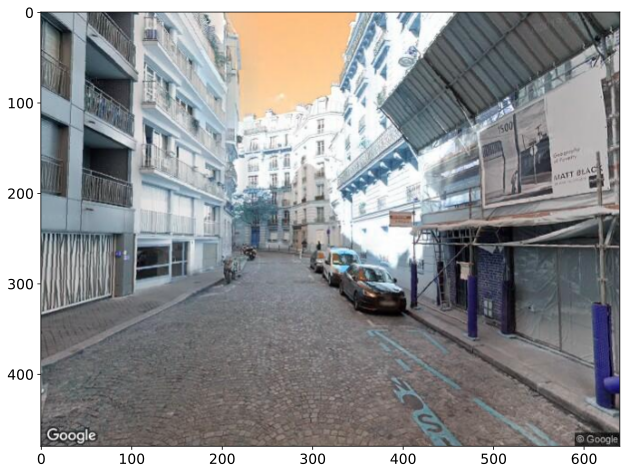

In [61]:
plt.imshow(img)

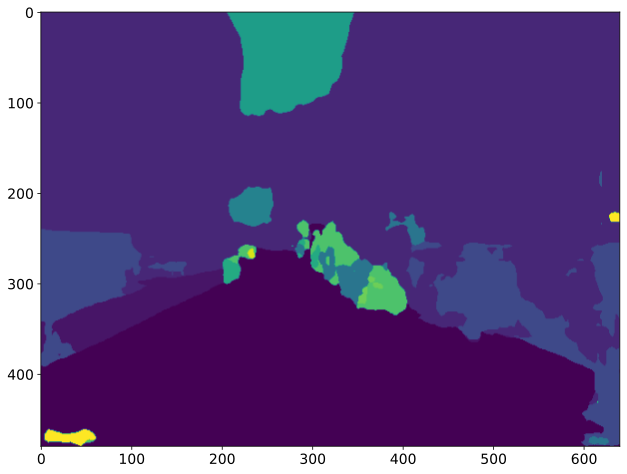

In [62]:
plt.imshow(seg_map)

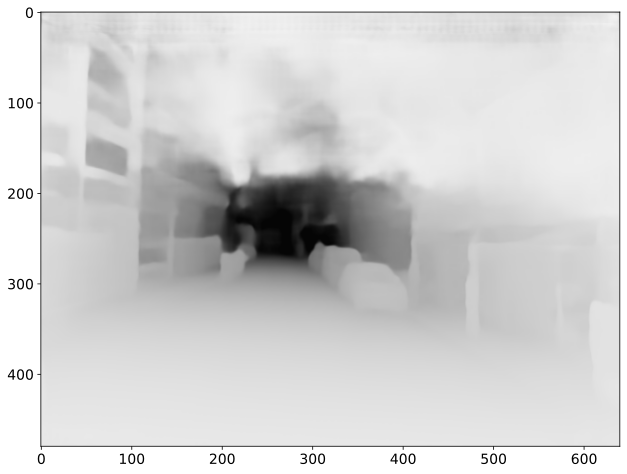

In [63]:
plt.imshow(BtsController.depth_map_to_rgbimg(depth_map))

In [64]:
%%time
from collections import Counter


Counter(list(seg_map.flatten())).most_common(7)

CPU times: user 107 ms, sys: 2.69 ms, total: 109 ms
Wall time: 111 ms


[(2, 165922),
 (0, 87989),
 (4, 24978),
 (10, 11946),
 (1, 6620),
 (13, 3682),
 (7, 2597)]

In [2]:
import open3d as o3d
import os
import sys
import cv2

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

# target = o3d.geometry.Image(np.array(depth_map * map_arr))


In [10]:
import numpy as np

pc = np.load("/home/ruslan/Загрузки/test (11).npy")

In [16]:
target = o3d.geometry.Image(np.array(1/ pc))

In [15]:
1 / pc

array([[0.00018822, 0.00018851, 0.000189  , ..., 0.00181498, 0.00188024,
        0.00193998],
       [0.00018828, 0.00018877, 0.00018946, ..., 0.00182313, 0.00185638,
        0.00188638],
       [0.00018837, 0.00018905, 0.00018993, ..., 0.00183156, 0.00182579,
        0.0018221 ],
       ...,
       [0.00016148, 0.00016158, 0.00016163, ..., 0.00027733, 0.00027639,
        0.00027554],
       [0.0001622 , 0.0001621 , 0.00016185, ..., 0.00027752, 0.00027736,
        0.0002772 ],
       [0.00016291, 0.00016258, 0.00016201, ..., 0.00027768, 0.00027825,
        0.00027874]], dtype=float32)

In [23]:
pc.shape

(480, 640)

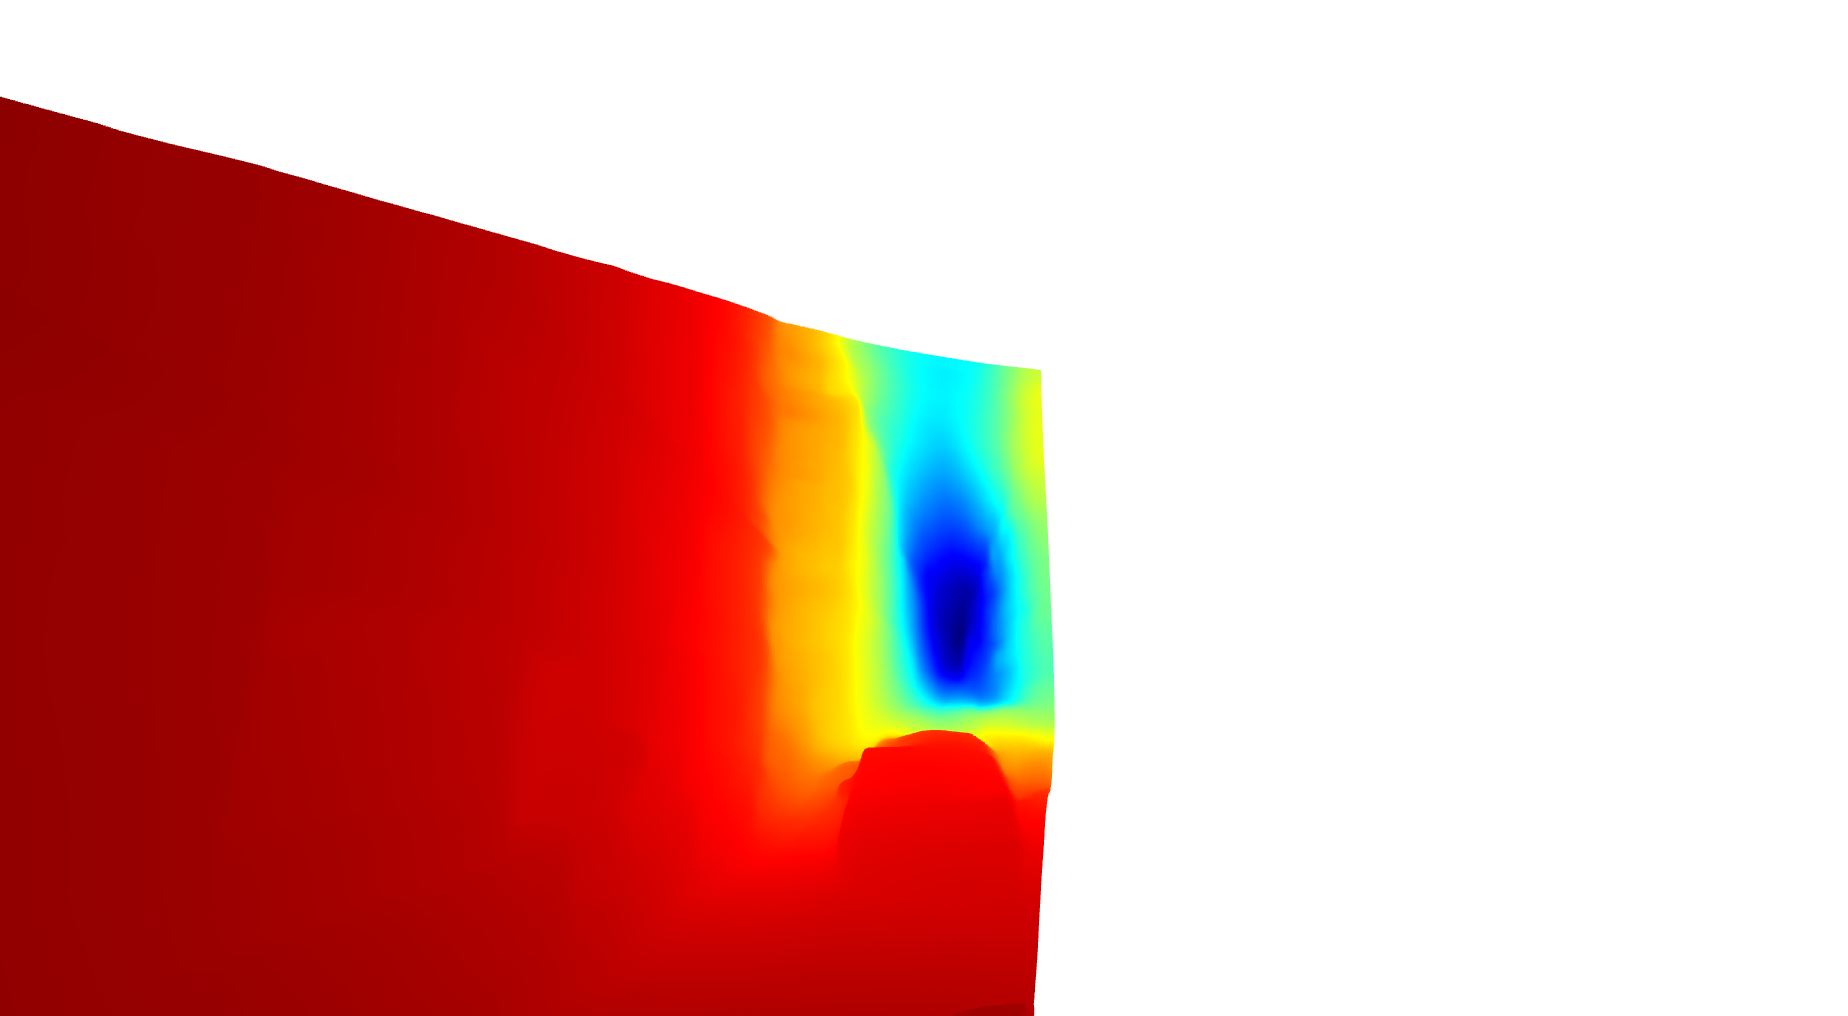

In [24]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    target,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.35)

In [70]:
from ransac_detector import *


croped_depth = crop_depth_map(depth_map, threshold=0.4)

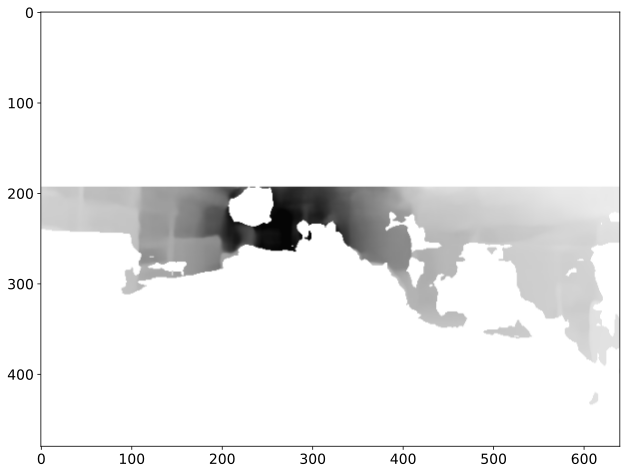

In [71]:
plt.imshow(BtsController.depth_map_to_rgbimg(depth_map * map_arr))

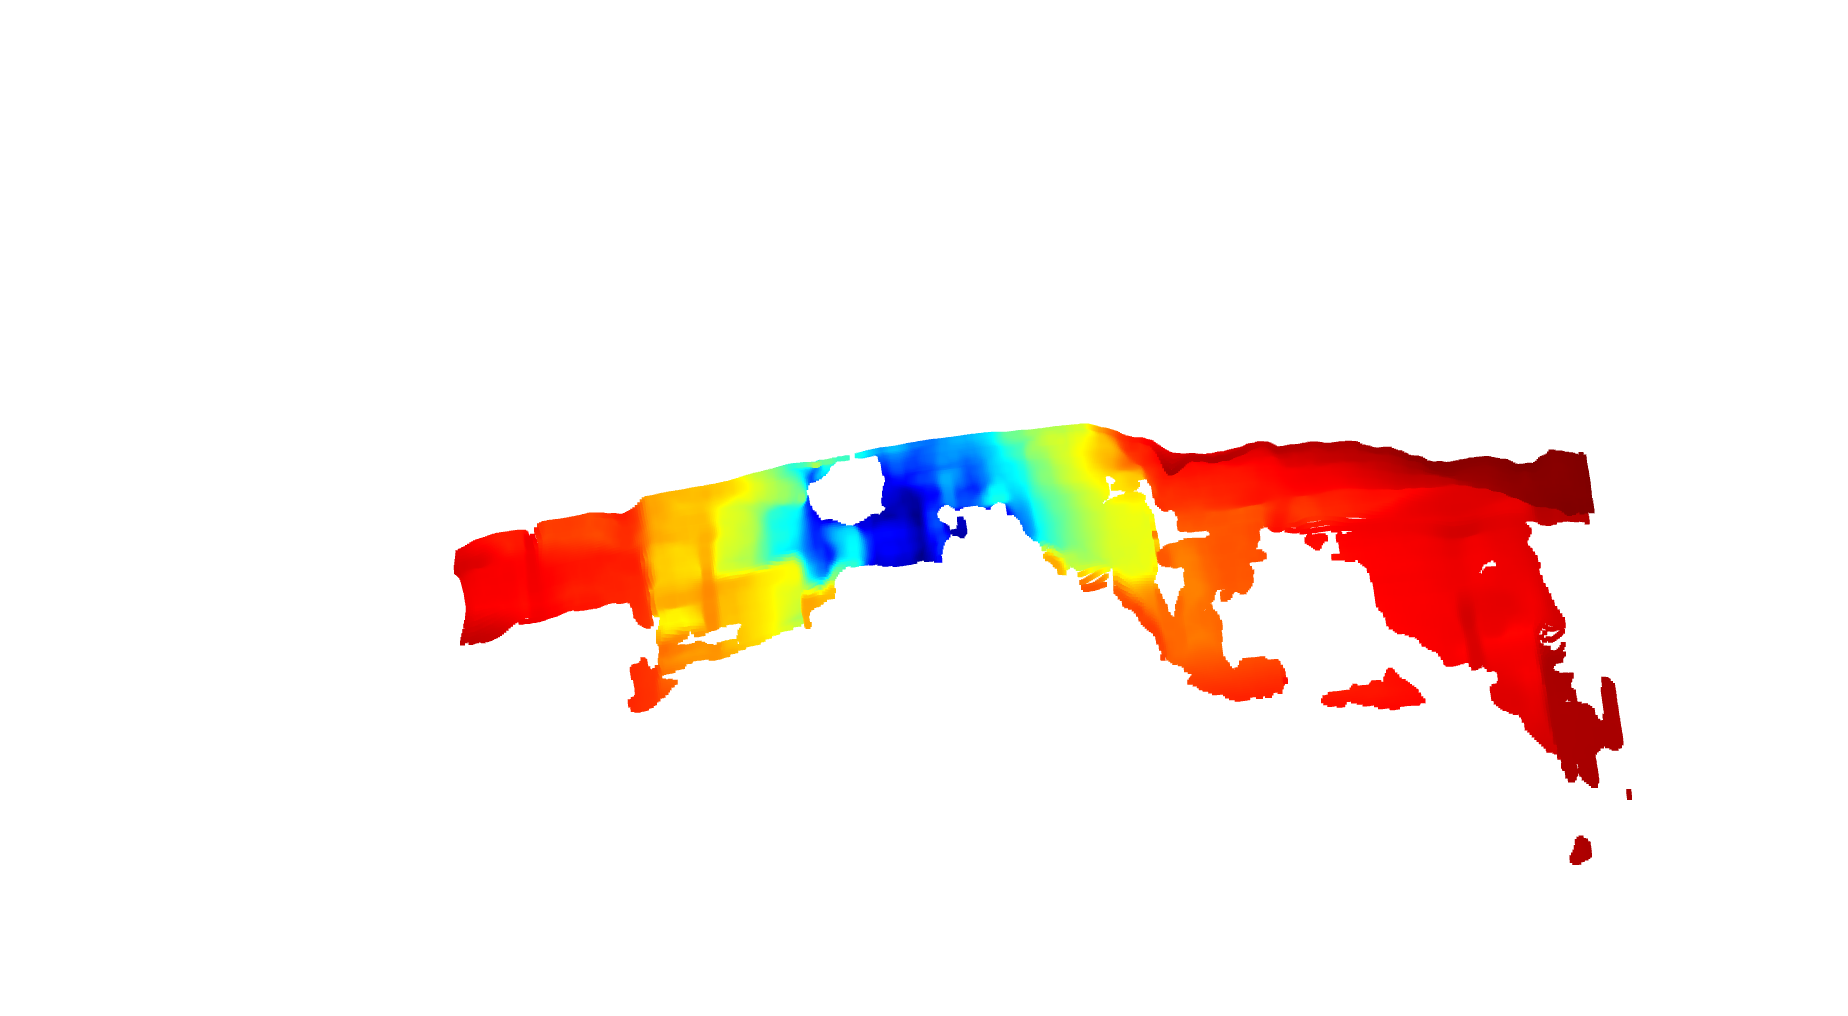

In [72]:
croped_target = o3d.geometry.Image(croped_depth * map_arr)

pcd = o3d.geometry.PointCloud.create_from_depth_image(
    croped_target,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.35)

In [73]:
downsm = downsample_pcd(pcd, voxel=0.2)

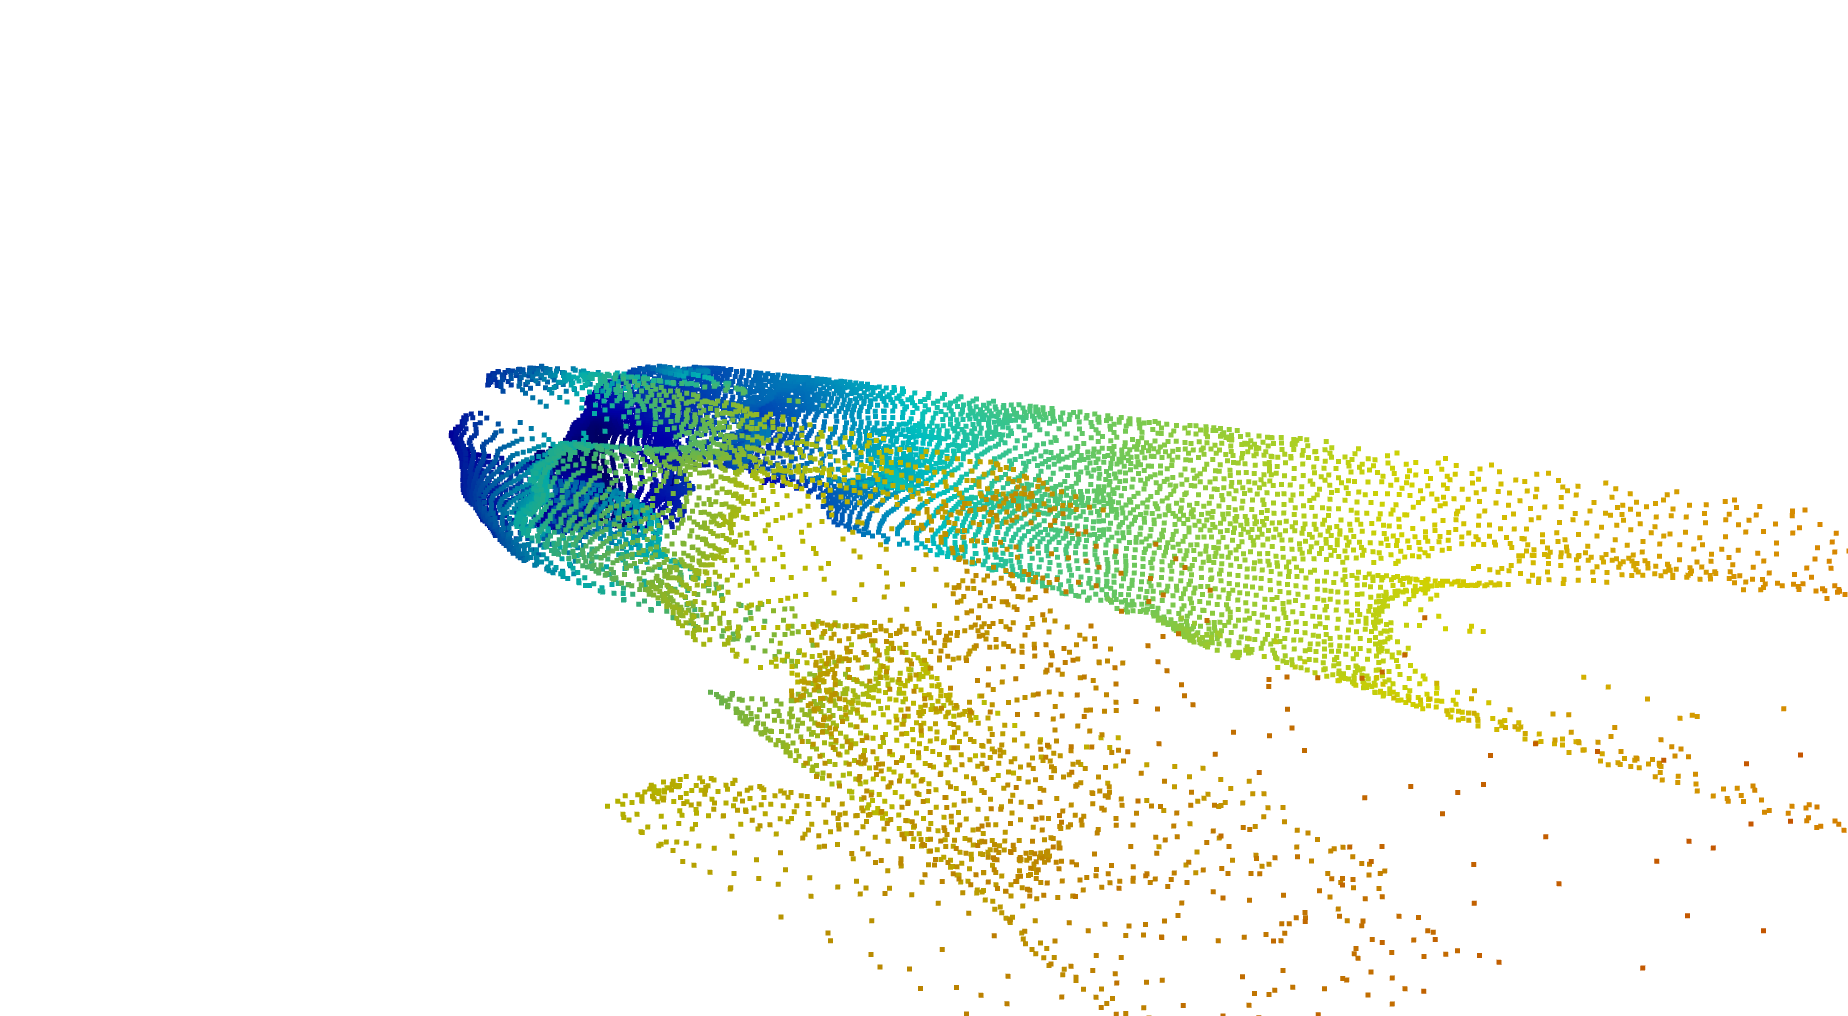

In [83]:
o3d.visualization.draw_geometries([downsm], zoom=0.35)

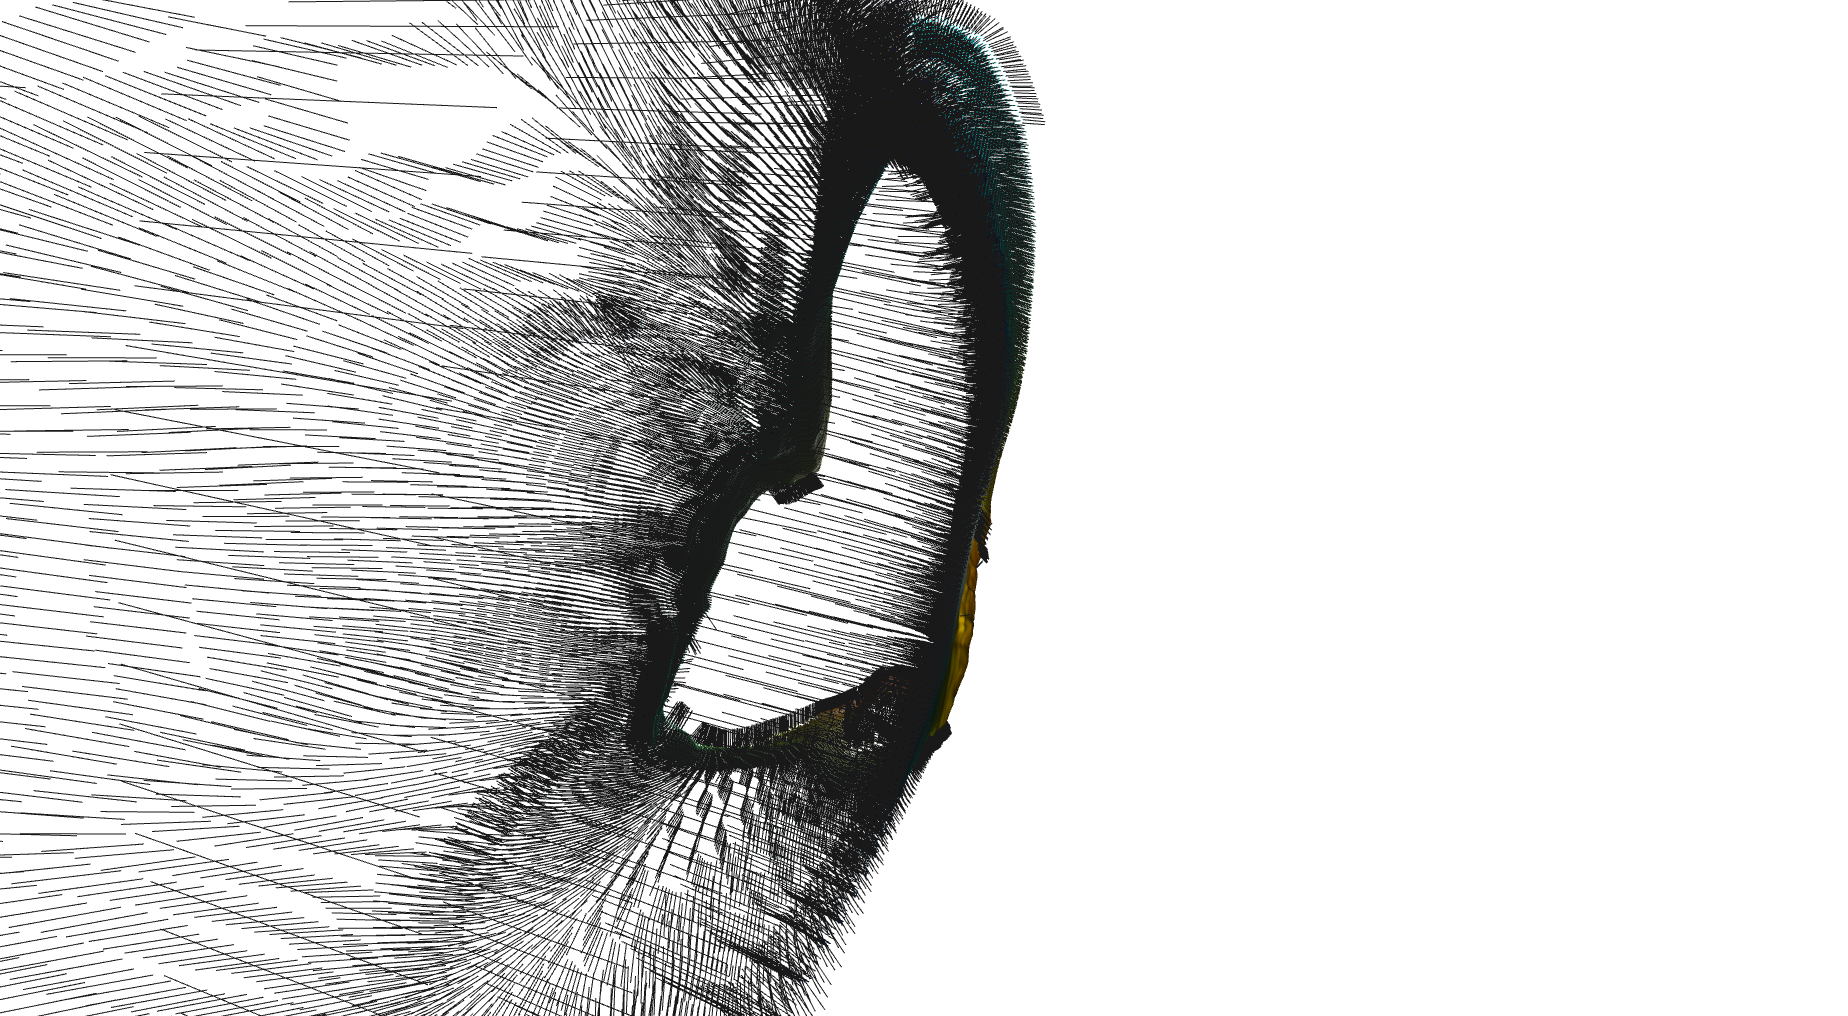

In [22]:
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))
o3d.visualization.draw_geometries([pcd], zoom=0.35)

Plane equation: 0.90x + 0.04y + 0.43z + 0.00 = 0


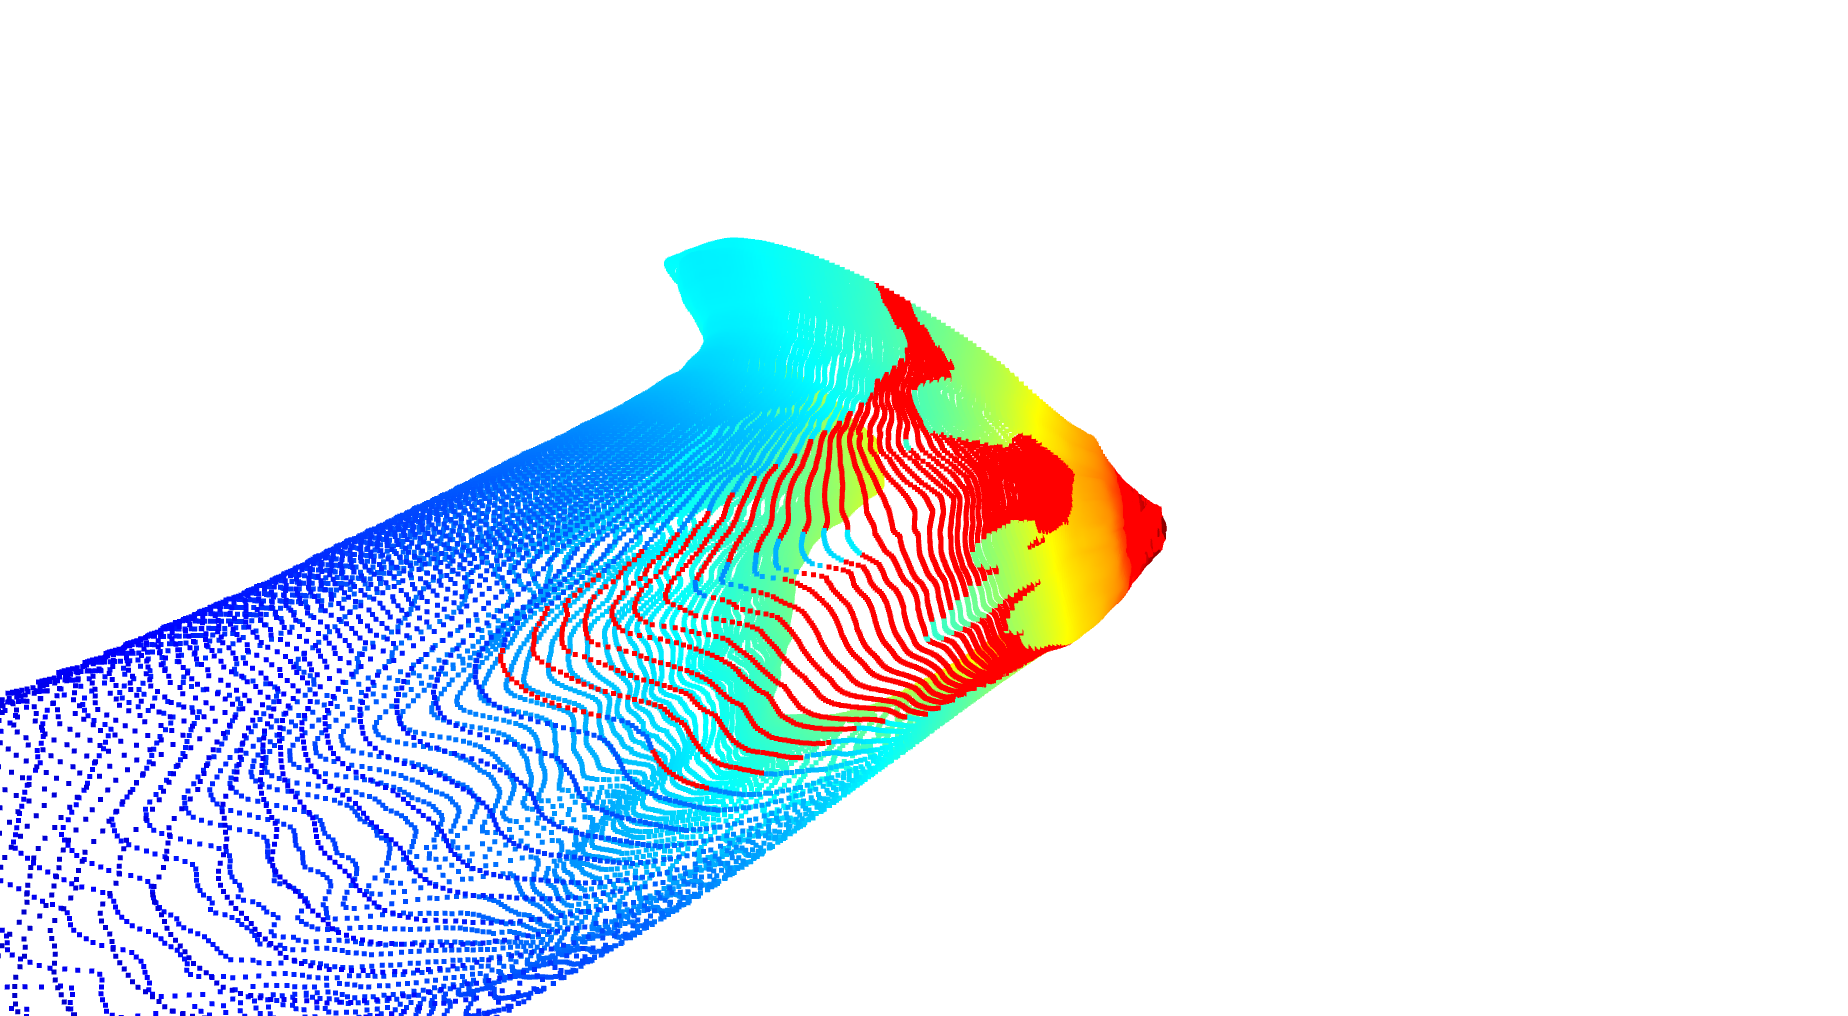

In [21]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.00001,
                                         ransac_n=3,
                                         num_iterations=100)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [20]:
plane_model, inliers = downsm.segment_plane(distance_threshold=0.000001,
                                         ransac_n=3,
                                         num_iterations=100)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud1 = downsm.select_by_index(inliers)
inlier_cloud1.paint_uniform_color([1.0, 0, 0])
outlier_cloud1 = downsm.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud, inlier_cloud1, outlier_cloud1],
                                  zoom=0.35)

NameError: name 'downsm' is not defined

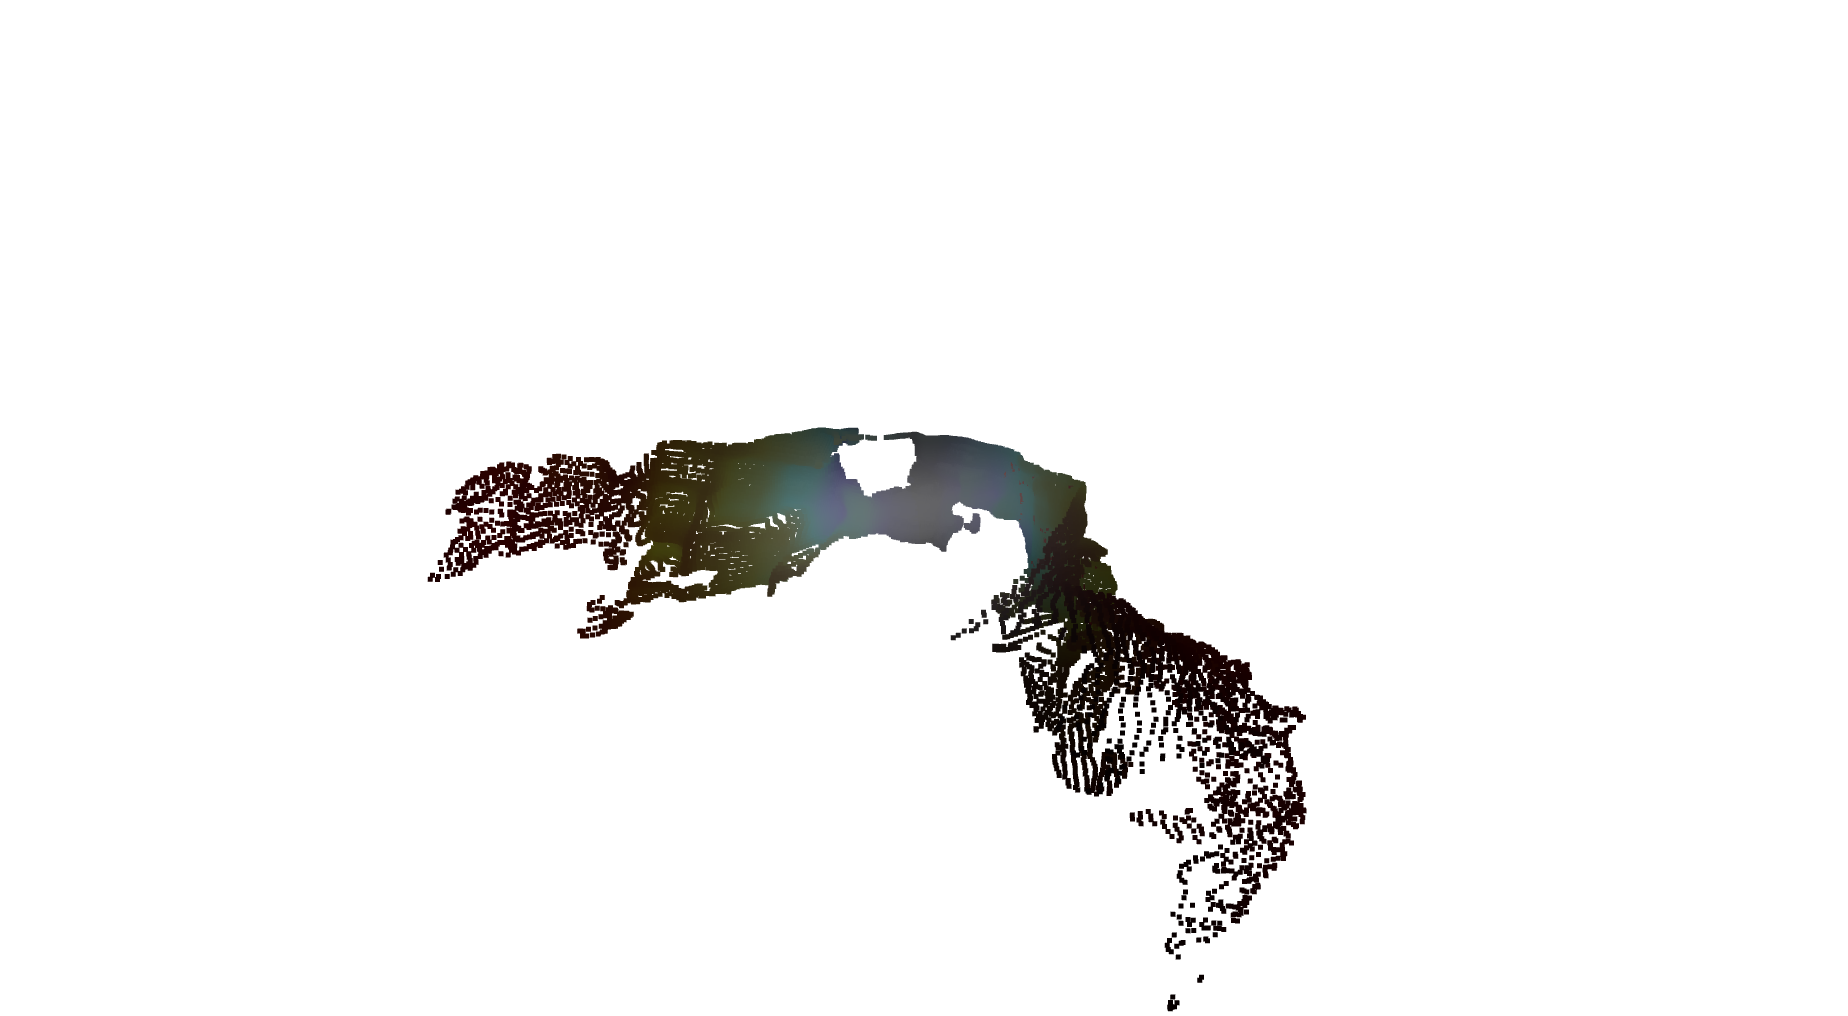

In [80]:
downsm.normals = o3d.utility.Vector3dVector(np.array([np.array([a, b, c]) for _ in range(np.asarray(downsm.normals).shape[0])]))

inlier_cloud1 = downsm.select_by_index(inliers)
inlier_cloud1.paint_uniform_color([1.0, 0, 0])
outlier_cloud1 = downsm.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud1, outlier_cloud1],
                                  zoom=0.35)